In [10]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import numpy.random
import scipy as sp
import scipy.stats

from ballot_comparison import findNmin_ballot_comparison_rates, ballot_comparison_pvalue
from hypergeometric import trihypergeometric_optim, simulate_ballot_polling_power
from fishers_combination import plot_fisher_pvalues

# Example of a hybrid audit in a large election with an exact tie

The numbers in this example may not be realistic, but serve as an example of what would happen in a tie election.

There are two strata. One contains every CVR county and the other contains every no-CVR county.
There were 2 million ballots cast in the election, 1.9 million in the CVR stratum and 100,000 in the no-CVR stratum.

The reported vote margin between A and B is 22,000 votes, a "diluted margin" of just over $1\%$.


Candidate | Reported Stratum 1 |  Reported Stratum 2 | Reported total 
---|---|---|---
A | 960,000 | 51,000 | 1,011,000
B | 940,000 | 49,000 | 989,000
Ballots | 1,900,000 | 100,000 | 2,000,000
Diluted margin | 1.05% | 2% | 1.1%

Assume there are only ballots for A and B.
In each stratum, the A reportedly received more votes than B, but they *actually* received exactly the same number.
In the CVR stratum, there were 960,000 votes reported for A and 940,000 votes reported for candidate B, a margin of 20,000 votes.
In the no-CVR stratum, there were 51,000 votes reported for A and 49,000 votes for B, a margin of 2,000 votes.

For any $\lambda$, the reported outcome of the election is correct if the overstatement of the margin in the CVR stratum is less than $22000\lambda$ votes and if the overstatement of the margin in the no-CVR stratum is less than $22000(1-\lambda)$ votes. 
For this example, we set $\lambda = 0.1$, which allocates most overstatement error to the no-CVR stratum.

We want to limit the risk of certifying an incorrect outcome to at most $\alpha=5\%$. 
We allocate risk unequally between the two strata.
The total risk is at most $1 - (1-\alpha_1)(1-\alpha_2)$.
One choice is to set $\alpha_1 = 1\%$ and to solve for the value of $\alpha_2$
which makes $1 - (1-\alpha_1)(1-\alpha_2) = \alpha$.
In this case, $\alpha_1=1\%$ and $\alpha_2 = 4.04\%$ achieve the desired risk limit.

We test the following pair of null hypotheses, using independent samples from the two strata:

* the overstatement in the CVR stratum is less than $22000\lambda$. We test at significance level
(risk limit) $\alpha_1$ using a ballot-level comparison audit

* the overstatement in the no-CVR stratum is less than $22000(1-\lambda)$. We test this at significance level (risk limit) $\alpha_2$ using a ballot-polling audit

If either null is not rejected, we hand count the corresponding stratum completely, adjust the null
in the other stratum to reflect the known tally in the other stratum, and then determine whether there needs to be
more auditing in the stratum that was not fully hand counted.


## Two scenarios

The audit will escalate to a full hand count in either of two scenarios:
1) the CVR stratum leads to a full hand count and the allowable margin in the no-CVR stratum is adjusted
2) the no-CVR stratum leads to a full hand count and the allowable margin in the CVR stratum is adjusted

We illustrate both below.


In [2]:
lambda1 = 0.1
lambda2 = 1-lambda1
alpha1 = 0.01
alpha2 = 0.0404
alpha = 0.05
reported_margin = 22000
actual_margin = 0
N1 = 1900000
N2 = 100000

# Scenario 1

# CVR stratum

We compute the sample size needed to confirm the election outcome, for a number of assumed rates of error in the population of ballots.

We take the chosen $\lambda$ from above and plug it in as the parameter `null_lambda` in the function below.

We set $\gamma = 1.03905$ as in "A Gentle Introduction to Risk-limiting Audits."

The reported margin in the stratum is just over $1\%$; this indicates that $1\%$ of ballots had some type of error.
We explore some possibilities below and find that no matter the case, the audit would escalate to a full hand count.

In [3]:
# Assuming that the audit will find 2-vote overstatements at 1%
findNmin_ballot_comparison_rates(alpha=alpha1, gamma=1.03905, 
                                r1=0, s1=0, r2=0.01, s2=0,
                                reported_margin=reported_margin, N=N1, null_lambda=lambda1)

nan

In [4]:
# Assuming that the audit will find 1-vote overstatements at rate 0.5% 
# and 1-vote understatements at rate 0.5%
findNmin_ballot_comparison_rates(alpha=alpha1, gamma=1.03905, 
                                r1=0.005, s1=0.005, r2=0, s2=0,
                                reported_margin=reported_margin, N=N1, null_lambda=lambda1)

nan

The CVR county audit would procede to a full hand count; no sample size would be large enough to confirm that the reported results were correct.

The full hand count would find that the margin in the CVR counties is actually 0 ballots.
We use this to adjust the allowable overstatement in the no-CVR stratum.
This result tells us that if the reported results are correct, then **all** of the reported margin occurs in the no-CVR stratum.

# No-CVR stratum

Below, we compute the sample size $n$ needed to confirm the election outcome.

Instead of the usual way of calculating the allowable overstatement, 
$$
    c = \text{reported margin in the stratum } - \lambda_2 \text{overall reported margin},
$$

the allowable overstatement is determiend based on subtracting the margin found by the CVR stratum hand count from the reported margin:

$$
    c = \text{overall reported margin} - \text{actual margin in the other stratum}.
$$

In this case, $c = 22,000$.

$c$ defines the null hypothesis. We test the null that the actual margin in the stratum is less than or equal to $c$: $A_{w, 2} - A_{\ell, 2} \leq c$. Here, $A_{w, 2}+A_{\ell,2}$ is an unknown nuisance parameter.

In practice, we will maximize the $p$-value over all possible pairs $(A_{w,2}, A_{\ell, 2})$ in the null.

In [5]:
# We don't know N_w, N_\ell so maximize the p-value over all possibilities.
c = 22000
print("margin that must be exceeded given the allowable overstatement is ", c)
simulate_ballot_polling_power(N_w=50000, N_l=50000, N=N2,
                             null_margin=c, n=500, alpha=alpha2,
                             reps=10000, verbose=False, stepsize=20)

margin that must be exceeded given the allowable overstatement is  22000
threshold margin is  149


0.0

A sample size of $n=500$ *never* allows us to stop the audit. We find the same result below using sample sizes of $n=1000$ and $n=5000$.

In [6]:
c = 22000
print("Allowable overstatement is ", c)
simulate_ballot_polling_power(N_w=50000, N_l=50000, N=N2,
                             null_margin=c, n=1000, alpha=alpha2,
                             reps=10000, verbose=False, stepsize=50)

Allowable overstatement is  22000
threshold margin is  275


0.0

In [7]:
c = 22000
print("Allowable overstatement is ", c)
simulate_ballot_polling_power(N_w=50000, N_l=50000, N=N2,
                             null_margin=c, n=5000, alpha=alpha2,
                             reps=10000, verbose=False, stepsize=50)

Allowable overstatement is  22000
threshold margin is  1219


0.0

# Scenario 2

# No-CVR stratum

In [9]:
# Assuming that the stratum reported margin is accurate

# We don't know N_w, N_\ell so maximize the p-value over all possibilities.
c = (51000 - 49000) - lambda2*reported_margin
print("Allowable overstatement is ", c)
simulate_ballot_polling_power(N_w=50000, N_l=50000, N=N2,
                             null_margin=c, n=500, alpha=alpha2,
                             reps=10000, verbose=False, stepsize=100)

Allowable overstatement is  -17800.0
threshold margin is  -49


0.9845

In $98.45\%$ of 10,000 simulations, sample size of 500 was sufficient to confirm the reported result in the no-CVR stratum is consistent with the overall reported margin. 

However, the CVR stratum would fail to confirm the outcome (as shown in Scenario 1). This would lead to adjusting the allowable overstatement in the no-CVR stratum and running the test again with $c=22,000$. 

Therefore, whether the CVR audit or the no-CVR audit finishes first, Scenario 1 will happen and all ballots will be recounted.


# Scenario 3: Using Fisher's method to combine audits

Even if we use large sample sizes in each stratum, the conclusion of Fisher's method will be to escalate the audit. In this case, we use sample sizes of $500$ in the CVR stratum and $1000$ in the no-CVR stratum. The Fisher's combined $p$-values are plotted for various values of $\lambda$. The maximum is around $0.22$, so we cannot confirm the reported results at risk limit $5\%$.

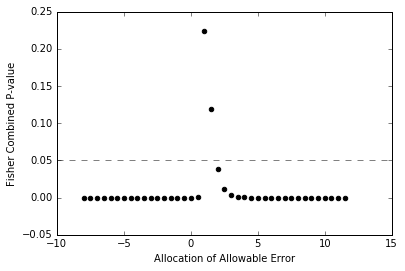

In [12]:
n1 = 500
n2 = 1000

N_w1 = int(N1/2)
N_l1 = int(N1/2)
N_w2 = int(N2/2)
N_l2 = int(N2/2)

cvr_pvalue = lambda alloc: ballot_comparison_pvalue(n=n1, gamma=1.03905, o1=int(0.005*n1), 
                                                    u1=int(0.005*n1), o2=0, u2=0, 
                                                    reported_margin=reported_margin, N=N1, 
                                                    null_lambda=alloc)


nocvr_pvalue = lambda alloc: trihypergeometric_optim(sample= np.array([0]*int(n2*N_l2/N2)+\
                                                                      [1]*int(n2*N_w2/N2)+\
                                                                [np.nan]*int(n2*(N2-N_l2-N_w2)/N2)), 
                                                     popsize=N2, 
                                                     null_margin=(N_w2-N_l2) - alloc*reported_margin)

plot_fisher_pvalues(N=(N1, N2), overall_margin=reported_margin, 
                    pvalue_funs=[cvr_pvalue, nocvr_pvalue], alpha=alpha)